# Librosa Audio Reader
- This notebook aims to do the same as the opensoundscape notebook but using torchlibrosa and librosa.
- Exploratory notebook to develop a method to read .flac .wav and .mp3 audio files from disk. 
- Audio files will also be linked to a pandas dataframe.
- This work is adapted from the 2021 notebook on processing audio data by stefan kahl: https://www.kaggle.com/code/stefankahl/birdclef2021-processing-audio-data/notebook
<br><br>

To Do:
- Read all of the images
- re-scale the spectrograms so that the frequency scale is centered on and bounded by the typical vocalization freq of the olive sided flycatcher.

In [120]:
from pathlib import Path
import pandas as pd
import numpy as np
import torchlibrosa as tl
import torch
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt


Load processed dataframe. 

In [78]:
# df = pd.read_csv(processed_df)

In [79]:
!pwd

/Users/mikeg/code/machine_learning/osfl_cnn_recognizer/notebooks/exploratory


Set relative paths. 

In [80]:
audio_read_path = Path('../../data/raw/recordings/')
image_save_path = Path('../../data/processed/img')
audio_save_path = Path('../../data/processed/audio')

In [81]:
!ls $audio_read_path

100027.mp3  292383.mp3  294588.mp3  316024.mp3  552930.flac 556615.flac
100030.mp3  292386.mp3  294589.mp3  316105.mp3  552931.flac 556617.flac
100031.mp3  292388.mp3  294590.mp3  316106.mp3  552932.flac 556625.flac
100033.mp3  292394.mp3  294593.mp3  316108.mp3  552938.flac 556634.flac
100034.mp3  292395.mp3  294597.mp3  316111.mp3  552939.flac 556636.flac
100035.mp3  292412.mp3  294601.mp3  316137.mp3  552946.flac 556647.flac
100036.mp3  292418.mp3  294607.mp3  316154.mp3  552947.flac 556648.flac
100042.mp3  292420.mp3  294610.mp3  316166.mp3  552951.flac 556660.flac
100060.mp3  292423.mp3  294615.mp3  316173.mp3  552955.flac 556664.flac
100062.mp3  292425.mp3  294617.mp3  316184.mp3  552961.flac 556666.flac
100092.mp3  292426.mp3  294618.mp3  316188.mp3  552963.flac 556668.flac
100099.mp3  292427.mp3  294619.mp3  316193.mp3  552964.flac 556670.flac
100120.mp3  292428.mp3  294625.mp3  316195.mp3  552967.flac 556675.flac
100121.mp3  292429.mp3  294722.mp3  316196.mp3  552970.flac 5566

## Load an audio file using librosa

In [132]:
audio, sr = librosa.load(audio_read_path/'305332.mp3')

In [133]:
sr

22050

The sample rate of this audio file ends up being 22050Hz, even though we know the audio file is 44.1khz by looking at the file and opening the file in Audacity. 

Librosa doc says:

`Audio will be automatically resampled to the given rate
(default ``sr=22050``).`

So we need to tell librosa to use 44.1kHz and make an alert in case we have lower sample rates in our database. 

In [134]:
audio, sr = librosa.load(audio_read_path/'479470.flac', sr=None, mono=True, duration=3.0)

In [135]:
sr

44100

### A note on sample frequencies.
The sample rate is 44.1 Khz . We will only be able to represent frequencies up to around 20kHz. These sample rates are chosen to represent frequencies within the range of human hearning. The bird call's we're looking at have their fundamental frequencies within this range, but there could be information in the higher harmonics of the bird calls which is either audible by other birds or could be useful for a CNN recognizer.

In [136]:
print('Signal Shape: ', audio.shape)
print('Signal Duration (s): ',  len(audio)/sr)
print(type(audio))

Signal Shape:  (104738,)
Signal Duration (s):  2.3750113378684805
<class 'numpy.ndarray'>


In [137]:
ipd.Audio(audio, rate=sr)

# Example from torchlibrosa docs
Torchlibrosa allows spectrogram calculation to be done on the GPU, which could be useful for making a more versatile model training pipeline. For now just the CPU based librosa functions are used. 
https://pypi.org/project/torchlibrosa/

# Spectrogram generation using Librosa 

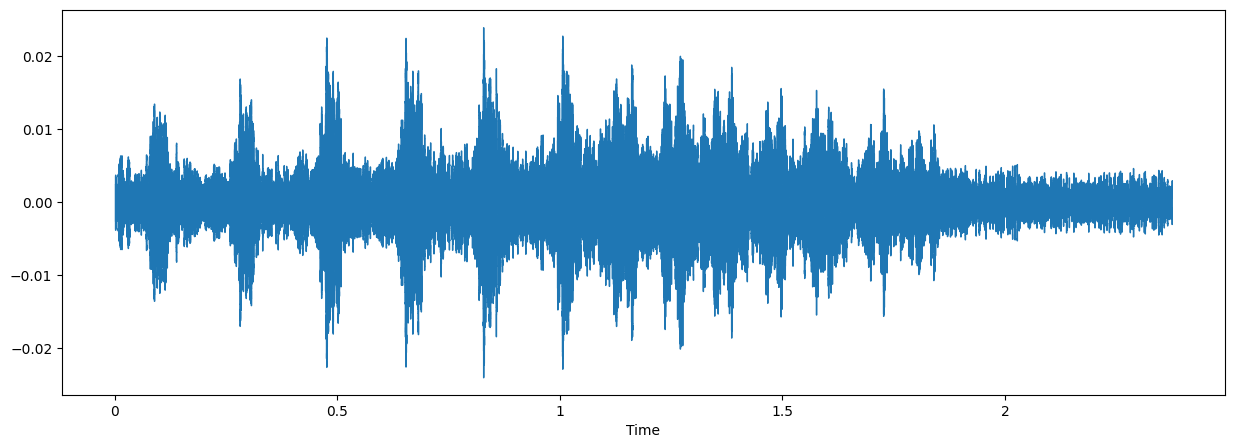

In [138]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(audio, sr=sr)
plt.show()

# Notes on spectrograms
https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Introductory_Electrical_Engineering/Electrical_Engineering_(Johnson)/05:_Digital_Signal_Processing/5.10:_Spectrograms

## short term fourier transform (STFT)
The STFT represents a signal in the time-frequency domain by
computing discrete Fourier transforms (DFT) over short overlapping
windows

In [150]:
spec = librosa.stft(audio)

# Lin scaled amplitude

1.0
(-2.525911-0.030203363j)


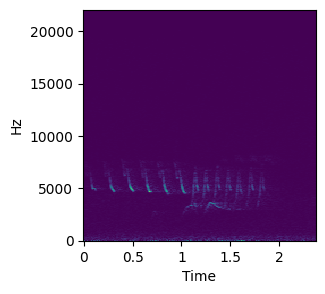

In [176]:
spec = librosa.stft(audio)
print(mag_spec.max())
print(spec.min())
plt.figure(figsize=(3,3))
librosa.display.specshow(mag_spec,
                         sr=sr,
                         x_axis='time', 
                         y_axis='hz',
                         cmap=plt.get_cmap('viridis')
                        )
plt.show()

# dB scaled amplitude

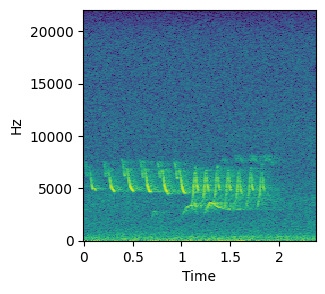

In [175]:
spec = librosa.stft(audio)
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(3,3))
librosa.display.specshow(spec_db,
                         sr=sr,
                         x_axis='time', 
                         y_axis='hz',
                         cmap=plt.get_cmap('viridis')
                        )
plt.show()

# Log(dB) scaled amplitude 
(check this - expected noise and harmonics to stand out more)

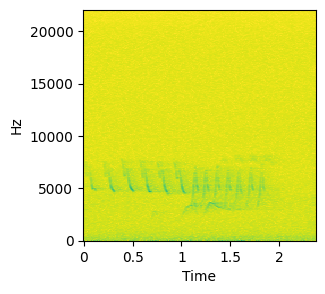

In [192]:
spec = librosa.stft(audio)
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
spec_log_db = librosa.amplitude_to_db(np.abs(spec_db), ref=np.max)

plt.figure(figsize=(3,3))
librosa.display.specshow(spec_log_db,
                         sr=sr,
                         x_axis='time', 
                         y_axis='hz',
                         cmap=plt.get_cmap('viridis')
                        )
plt.show()

Prior to taking the absolute value of the wave, the data is stored as a complex array of magnitudes and phases. Once we take np.abs(spec) we're just looking at the magnitde component, and the complex number description of the waveform is discarded. Here's the error generated if we don't take abs(spec)

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_6984/1613526318.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spec_db = librosa.amplitude_to_db(spec, ref=np.max)

## The best plot looks like the dB scale. 

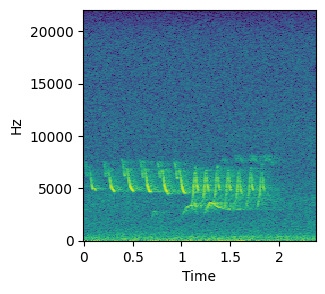

In [193]:
spec = librosa.stft(audio)
spec_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)
plt.figure(figsize=(3,3))
librosa.display.specshow(spec_db,
                         sr=sr,
                         x_axis='time', 
                         y_axis='hz',
                         cmap=plt.get_cmap('viridis')
                        )
plt.show()

In [195]:
spec.shape

(1025, 205)

# Frequency resolution vs. time resolution trade off

## Notes on windows, overlap, length and n_fft.  
Taken from librosa docs and from https://eng.libretexts.org/Bookshelves/Electrical_Engineering/Introductory_Electrical_Engineering/Electrical_Engineering_(Johnson)/05:_Digital_Signal_Processing/5.10:_Spectrograms

__n_fft__ is the number of samples per frame.

__hop_length__ is the number of samples between successive frames. If we leave this equal to the n_fft, then the application of a window to each frame will effectively amplitude modulate our input signal. Better to overlap the frames by having hop_length = n_fft / 2 or n_fft / 4

__win_length__ Each frame of audio is windowed by window of length win_length and then padded with zeros to match n_fft.

Smaller values improve the temporal resolution of the STFT (i.e. the ability to discriminate impulses that are closely spaced in time) at the expense of frequency resolution (i.e. the ability to discriminate pure tones that are closely spaced in frequency). This effect is known as the time-frequency localization trade-off and needs to be adjusted according to the properties of the input signal y.

If window length is unspecified it defaults to win_length=n_fft

Window length and n_fft should be a power of 2 so that the fast fourier transform algorithm can run efficiently.

/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_6984/2005845329.py:12: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spec_db = librosa.amplitude_to_db(spec, ref=np.max)


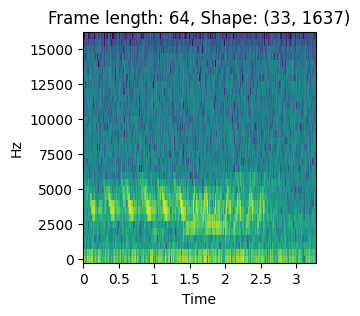

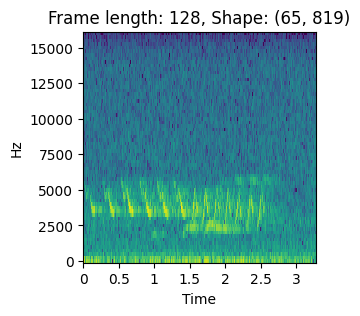

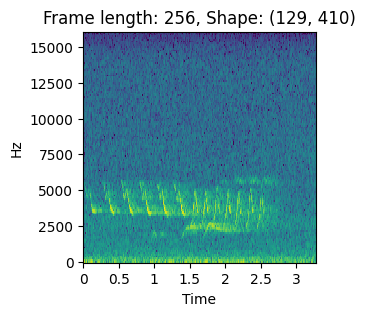

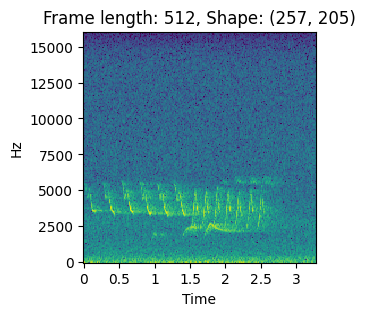

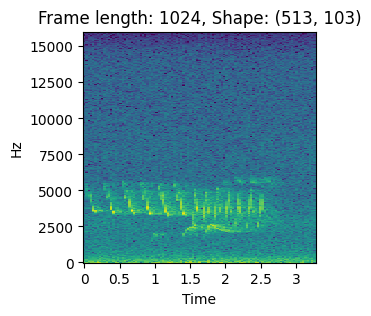

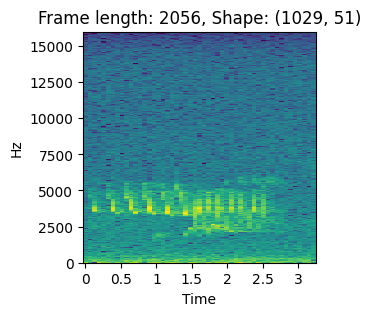

In [200]:
# Try a few frame lengths. 
# Make multiple plots to see effect of changing frame length
frame_lengths = [64, 128, 256, 512, 1024, 2056]
for n_fft in frame_lengths:
    hop_length = n_fft
    win_length = n_fft
    
    spec = librosa.stft(audio, 
                       n_fft=n_fft, 
                       hop_length=hop_length
                       )
    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    
    plt.figure(figsize=(3, 3))
    plt.title('Frame length: ' +str(n_fft) +', Shape: ' + str(spec_db.shape))
    
    librosa.display.specshow(spec_db,
                            sr=32000, 
                            hop_length=hop_length, 
                            x_axis='time',
                            y_axis='hz',
                            cmap=plt.get_cmap('viridis'))
plt.show()

# Try using the mel scale

https://www.kaggle.com/code/mgallimore88/birdclef-2021-audio-processing-eda/edit/run/115330709

In [11]:
spec = Spectrogram.from_audio(audio)

In [12]:
image = spec.to_image(shape=image_shape, invert=True)

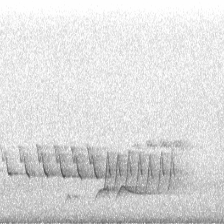

In [13]:
image

Already we see an image which might not be an olive sided flycatcher. 

Turn this into a function then try on an mp3. 

In [14]:
def show_spec_from_audio(clip_name):
    audio = Audio.from_file(audio_read_path/clip_name)
    spec = Spectrogram.from_audio(audio)
    image = spec.to_image(shape=image_shape, invert=True)
    return image

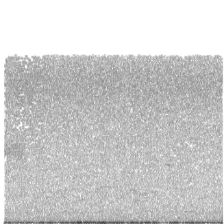

In [15]:
show_spec_from_audio('100027.mp3')